# STA Problem Set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pprint
from scipy.io import loadmat

## Load the Data

In [2]:
d = loadmat('LGN_FFdata.mat')
spiks = d['FFspks'][0] # number is number of seconds from the start for that spike
stims = d['FFstim'] # the magnitude of the stimulus presentation at each time step
dt = d['DTstim'][0] # time between each stimulus

## 1. Temporal receptive field of a neuron

### A. Average stimulus value for all spike times

In [3]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims, dt):
    max_stim = len(stims) * dt
    # put a tiny amount of extra time at the end of the bin to make sure that we include the extreme times
    epsilon = dt / 2
    return np.histogram(spiks, bins=np.arange(0, max_stim+epsilon, dt), range=(0, max_stim))[0]


# combine the spiks and stims by as columns
def merge_spiks_and_stims(spiks, stims, dt):
    spiks_per_stim = associate_spiks_to_stims(spiks, stims, dt)
    return np.column_stack([stims.flatten(), spiks_per_stim])

In [4]:
merged = merge_spiks_and_stims(spiks, stims, dt)

# average stimulus for all spike times
np.sum(merged[:,0] * merged[:,1]) / np.sum(merged[:,1])

0.05954608809527265

### B. STA of the neuron

In [5]:
# shifts vector by the amount (shift can be positive or negative)
# fills the empty elements with zeros
def shift_vector(vector, shift):
    if shift > len(vector):
        shift = len(vector)
    elif shift < 0 and abs(shift) > len(vector):
        shift = -len(vector)
    
    if shift > 0:
        shifted = np.concatenate((np.zeros((shift)), vector[:-shift]), axis=None)
    elif shift < 0:
        shifted = np.concatenate((vector[abs(shift):], np.zeros((abs(shift)))), axis=None)
    else:
        shifted = vector
    
    return shifted


def calc_sta(stims, spiks, dt, num_lags):
    # embedding matrix is NxL (N = number of trials (i.e. len of stimulus), L = number of lags to use)
    embedding = np.zeros((len(stims), num_lags)) # add an extra column for the stims
    for lag in range(0, num_lags):
        lagged_stim = shift_vector(stims, lag)
        embedding[:,lag] = lagged_stim.T # put the shifted stimulus in the lag column

    response = merge_spiks_and_stims(spiks, stims, dt)[:,1]
    sta = np.matmul(embedding.T, response)
    return sta

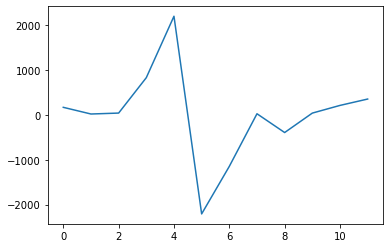

In [6]:
# moving window across the binned spikes, in 100ms (.1) bins
TIME_TO_LOOK_BACK = .1 # 100 ms
num_lags = math.ceil(TIME_TO_LOOK_BACK / dt)

sta = calc_sta(stims, spiks, dt, num_lags)
plt.plot(sta)

## 2. Calculating the spiking nonlinearity

### A. Calculate the stimulus convolved with the receptive field

In [7]:
def g_convolve( s, k ):
    # pad to make causal
    k2 = np.zeros(len(k)*2-1)
    k2[len(k)-1:] = [i for i in k]
    g = np.convolve( s, k2, mode='same')
    return g


# test that the g_convolve does what we expect in the happy path
def test_g_convolve_happy():
    test_kernel = np.array([0, 0.5, 1])
    test_stims = np.array([1, 2, 4, 2, 4, 6])
    
    return g_convolve(test_stims, test_kernel)


test_g_convolve_happy()

array([0. , 0.5, 2. , 4. , 5. , 4. ])

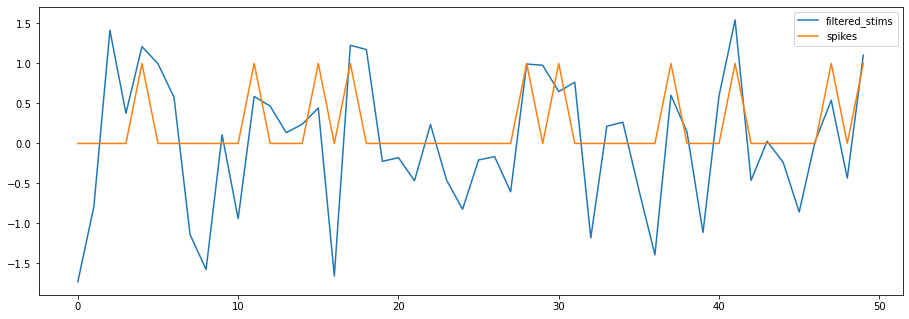

In [8]:
filtered_stims = g_convolve(stims[:,0], sta)
#filtered_stims are g

g = sta / np.std(filtered_stims)

filtered_stims_normed = g_convolve(stims[:,0], g)

axt = plt.axes([1, 1, 2, 1])
axt.plot(filtered_stims_normed[50:100], label='filtered_stims')
axt.plot([r for s,r in merged[50:100]], label='spikes')
axt.legend()
plt.show()

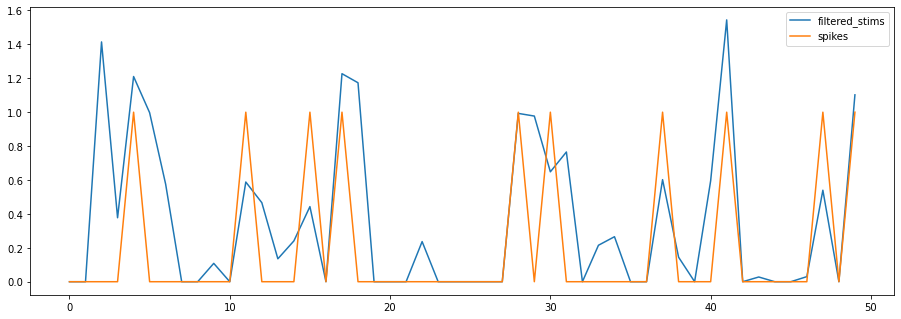

In [9]:
# remove negative values from the filter response
nonneg_filtered_stims_normed = list(map(lambda x: x if x >= 0 else 0, filtered_stims_normed))

axt = plt.axes([1, 1, 2, 1])
axt.plot(nonneg_filtered_stims_normed[50:100], label='filtered_stims')
axt.plot([r for s,r in merged[50:100]], label='spikes')
axt.legend()
plt.show()

### B. Calculate the histogram for the value of the filtered stimulus

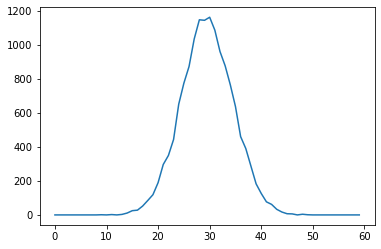

In [10]:
histb = np.histogram(filtered_stims_normed, bins=np.arange(-6, 6.2, 0.2))[0]
plt.plot(histb)

### C. Calculate the histogram for the value of the filtered stimulus for just the spike times

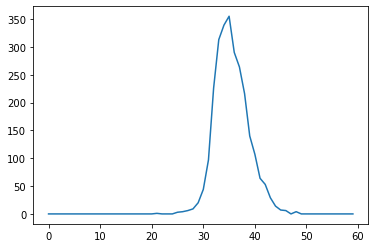

In [11]:
# TODO: this is wrong, we don't just want g(stim) when there is a spike,
#       we want to multiply the value of g by the number of spikes
indices_when_spiking = (merged[:,1] > 0).nonzero()[0]
filtered_stims_normed_when_spiking = filtered_stims_normed[indices_when_spiking]
histc = np.histogram(filtered_stims_normed_when_spiking, bins=np.arange(-6, 6.2, 0.2))[0]
plt.plot(histc)

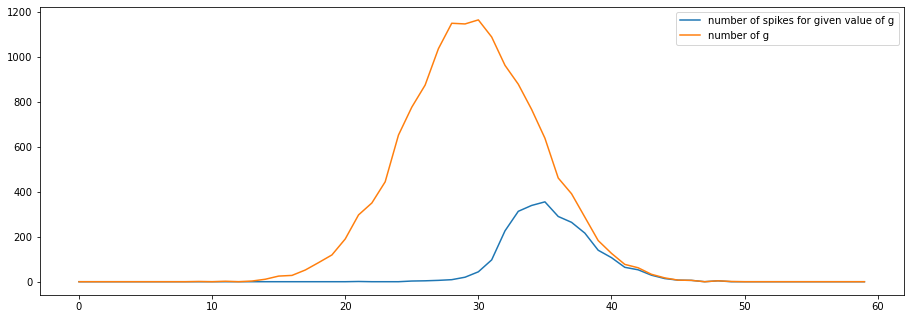

In [12]:
axc = plt.axes([1, 1, 2, 1])
axc.plot(histc, label='number of spikes for given value of g')
axc.plot(histb, label='number of g')
axc.legend()
plt.show()

### D. Plot the spiking nonlinearity

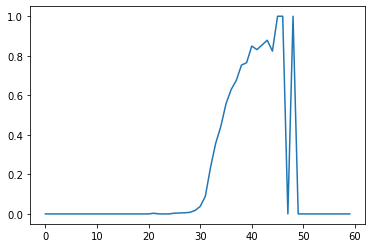

In [13]:
# add a tiny amount to the zeros in histb to prevent divide by zero errors
histb = histb + 1e-10

plt.plot(histc / histb)

## 3. Model Predictions and Cross-Validation

## Load the data

In [14]:
# the stims are the same for each trial?
stimsr = d['FFstimR'][:,0]
# split the trials into rows, using -1 as the flag variable
spiksr = []
spikr = []
for x in d['FFspksR'][0]:
    if x == -1:
        spiksr.append(np.array(spikr))
        spikr = []
        continue
    spikr.append(x)

## A. Calculate the firing rate as a function of time

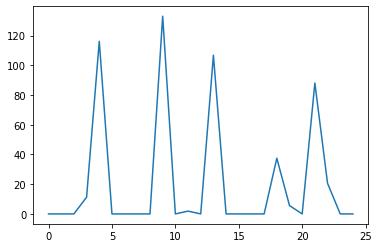

In [15]:
# 1. merge the stimsr and spiksr for each trial
mergedrs = []
for spiks in spiksr:
    mergedrs.append(merge_spiks_and_stims(spiks, stimsr, dt))
mergedrs = np.array(mergedrs)

# calculate the neurons firing rate as a function of time, using a bin size DTstim
# r(t) = n_spk(t) / dt
# sum over the columns and divide by dt
rate_t = [np.mean(mergedr) for mergedr in mergedrs[:,:,1].T] / dt

# plot the firing rate between 800ms and 1000ms, vertical axis units in Hz
plt.plot(rate_t[math.floor(.8/dt):math.ceil(1/dt)])

## B. Calculate the filtered response to the stimulus

1.0508516473383285


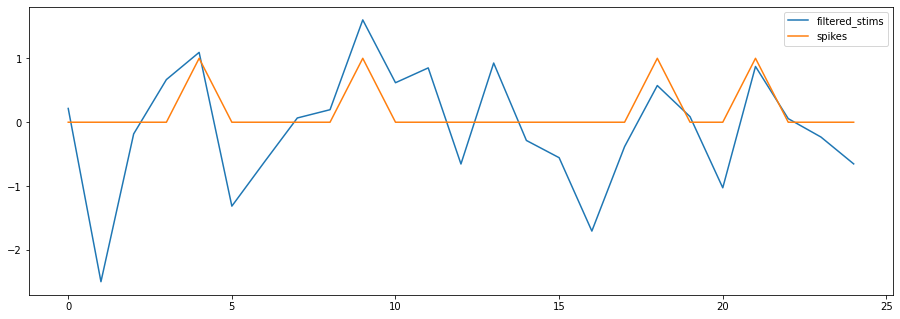

In [16]:
filtered_stimsr = g_convolve(stimsr, g)

print(np.std(filtered_stimsr))

axt = plt.axes([1, 1, 2, 1])
axt.plot(filtered_stimsr[math.floor(.8/dt):math.ceil(1/dt)], label='filtered_stims')
axt.plot(mergedrs[0,math.floor(.8/dt):math.ceil(1/dt),1], label='spikes')
axt.legend()
plt.show()

## C. Calculate the predicted firing rate of your neural model

In [17]:
nl = histc / histb

In [18]:
def nl_func(nl, g_stim):
    x = np.arange(-6, 6, 0.2)
    # find the closest nl value for the given g_stim
    for i in range(len(x)-1):
        if g_stim >= x[i] and g_stim < x[i+1]:
            return nl[i]
    return -1

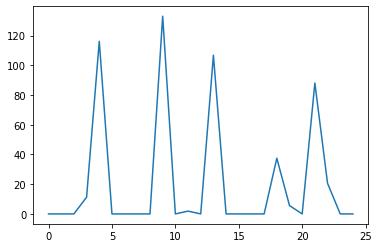

In [19]:
# plot the firing rate between 800ms and 1000ms, vertical axis units in Hz
plt.plot(rate_t[math.floor(.8/dt):math.ceil(1/dt)])

189.2438033786207


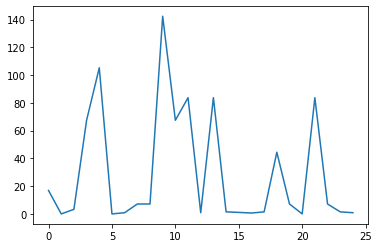

In [20]:
# get the probability of a spike at each stimulus presentation
pred_prob_t = np.array(list(map(lambda x: nl_func(nl, x), filtered_stimsr)))

# multiply this by the max number of spikes to change this to Hz
max_num_spikes = np.max(rate_t)
print(max_num_spikes)

pred_t = pred_prob_t * max_num_spikes

# plot it
plt.plot(pred_t[math.floor(.8/dt):math.ceil(1/dt)])

In [21]:
r2 = 1 - (np.var(rate_t - pred_t) / np.var(rate_t))
r2

0.5684893933907347

## 4. High-Time Resolution Failing of the LN Model

In [22]:
# do experiment for different time resolutions and plot the r2 at each time resolution

def train(_stims, _spiks, _dt, time_scale=1):
    # 1. scale the stims and dt by the time_scale
    spiks = _spiks # spiks do not need to be scaled, they are already in ms
    stims = np.array([[_stim]*time_scale for _stim in _stims]).flatten()
    dt = _dt / float(time_scale)
    
    
    # 2. calculate the unnormalized STA for the neuron
    merged = merge_spiks_and_stims(spiks, stims, dt)
    sta = calc_sta(stims, spiks, dt, num_lags=12*time_scale) # 12 lags for time_scale==1, otherwise adjust that
    
    spike_rate = merged[:,1].T / dt
    max_spike_rate = np.max(spike_rate)
    
    
    # 3. convolve the stims with the sta and normalize to generate g --> g()
    g = g_convolve(stims, sta)
    # normalize g by the std dev of g and then recompute the filter responses over the stimulus
    g_std = np.std(g)
    g = sta / g_std
    g = g_convolve(stims, g)
    
    histg = np.histogram(g, bins=np.arange(-6, 6.2, 0.2))[0]
    
    
    # 4. calculate the spiking nonlinearity function --> r()
    # filter the filtered_stims for just when there is a spike
    indices_when_spiking = (merged[:,1] > 0).nonzero()[0]
    
    # TODO: this is wrong, we don't just want g(stim) when there is a spike,
    #       we want to multiply the value of g by the number of spikes
    # TODO: don't hard code this range, it should probably be dependent on the time scale
    histg_spiking = np.histogram(g[indices_when_spiking], bins=np.arange(-6, 6.2, 0.2))[0]
    
    nl = histg_spiking / (histg + 1e-10)  # add some tiny value to the denom to prevent divide by zero
    nl = np.array(list(map(lambda x: x if not np.isnan(x) else 0, nl))) # remove the NaNs from nl

    
    # 5. return the trained sta, nl, std, and max_spike_rate
    return sta, nl, g_std, max_spike_rate


def test(sta, nl, g_std, max_spike_rate, _test_stims, _test_spiks, _dt, time_scale=1):
    # 0. stretch the test_stims by the time scale
    test_stims = np.array([[_stim]*time_scale for _stim in _test_stims]).flatten()
    test_spiks = _test_spiks # spiks do not need to be scaled, they are already in ms
    dt = _dt / float(time_scale)
    
    
    # 1. apply the sta to the test_stims --> g(stim)
    g = g_convolve(test_stims, sta)

    # TODO: do I need to do this again like this?
    # normalize g by the std dev of the training g and then recompute the filter responses over the stimulus
    g = sta / g_std
    g = g_convolve(test_stims, g)
    
    
    # 2. get the probability of a spike at each stimulus presentation --> r(g(stim))
    pred_probs = np.array([nl_func(nl, val) for val in g])

    test_merged = np.array([merge_spiks_and_stims(test_spik, test_stims, dt) for test_spik in test_spiks])
    actual_rates = [np.mean(val) for val in test_merged[:,:,1].T] / dt
    
    # multiply this by the max number of spikes to change this to Hz
    #pred_rates = pred_probs * max_spike_rate
    pred_rates = pred_probs * np.max(actual_rates)
    
    # return predicted vs. actual
    return pred_rates, actual_rates

In [23]:
# load the data
d = loadmat('LGN_FFdata.mat')

train_spiks = d['FFspks'][0].flatten() # number is number of seconds from the start for that spike
train_stims = d['FFstim'].flatten() # the stimlus value at the time step
dt = d['DTstim'][0].flatten() # time between each stimulus

# the stims are the same for each trial
test_stims = d['FFstimR'][:,0]
# split the trials into rows, using -1 as the flag variable
test_spiks = []
test_spik = []
for x in d['FFspksR'][0]:
    if x == -1:
        test_spiks.append(np.array(test_spik))
        test_spik = []
        continue
    test_spik.append(x)
# to avoid missing the final trial, add it at the end
test_spiks.append(test_spik)

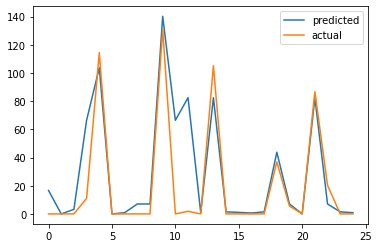

R2 0.5684893933907348


In [24]:
# train and test the model
TIME_SCALE = 1

sta, nl, g_std, max_spike_rate = train(train_stims, train_spiks, dt, time_scale=TIME_SCALE)
pred_rates, actual_rates = test(sta, nl, g_std, max_spike_rate, test_stims, test_spiks, dt, time_scale=TIME_SCALE)
plt.plot(pred_rates[math.floor(.8/dt):math.ceil(1/dt)], label='predicted')
plt.plot(actual_rates[math.floor(.8/dt):math.ceil(1/dt)], label='actual')
plt.legend()
plt.show()

r2 = 1 - (np.var(actual_rates - pred_rates) / np.var(actual_rates))
print('R2', r2)

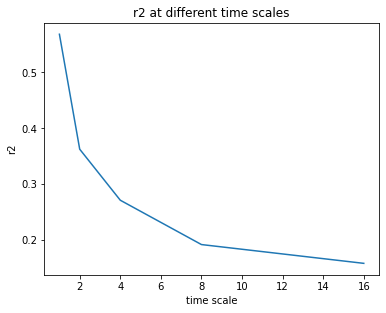

In [25]:
time_scales = [1, 2, 4, 8, 16]
r2s = []
for ts in time_scales:
    sta, nl, g_std, max_spike_rate = train(train_stims, train_spiks, dt, time_scale=ts)
    pred_rates, actual_rates = test(sta, nl, g_std, max_spike_rate, test_stims, test_spiks, dt, time_scale=ts)
    r2 = 1 - (np.var(actual_rates - pred_rates) / np.var(actual_rates))
    r2s.append(r2)

fig = plt.figure()
fig.subplots_adjust(top=1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('time scale')
ax1.set_ylabel('r2')
ax1.set_title('r2 at different time scales')
ax1.plot(time_scales, r2s)